In [116]:
from utils.dataset import aircraft_camera_data
import utils.object_detector as od
import math
import os
import matplotlib.pyplot as plt
import cv2
import time
import torch
import tqdm.notebook as tqdm
import numpy as np
import pickle as pkl

In [117]:
t = 1 # Time - 5
r = 1 # Runs - 3
w = 1 # Weather - 5

data_indexes = [1,2] # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

# Main Object Detector
mod = od.main_object_detector()

In [122]:
# Predicting using optimized YOLO
img = acd.get_frame_from_video(3000, size = (1280, 1920), batch_size = 1)
box, score = mod.single_infer(img)

AutoSegmentation : 0.04868054389953613
Final Inference  : 0.007210969924926758
Post Processing  : 0.0003437995910644531


In [123]:
%timeit box, score = mod.single_infer(imgs, verbose = False)

31.7 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


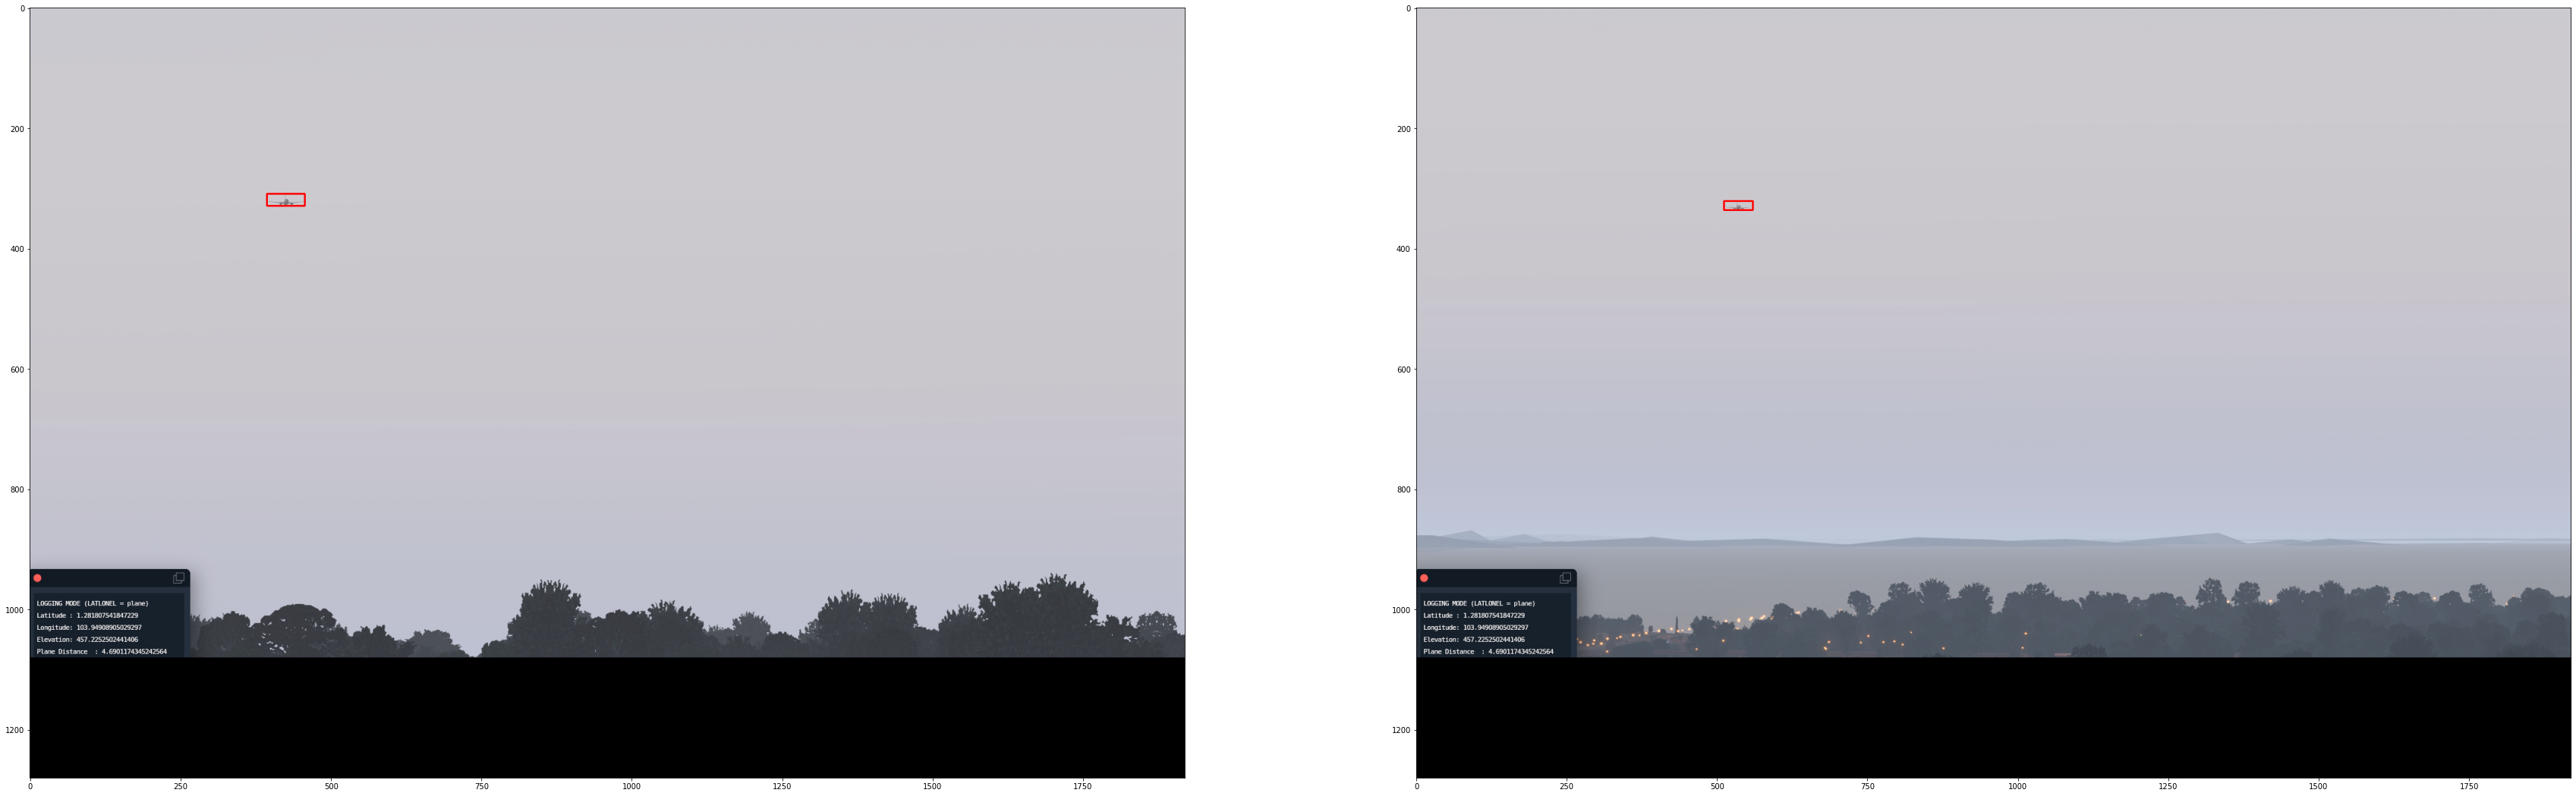

In [124]:
fig, ax = plt.subplots(1, 2,figsize = (60,60))
fig, ax = mod.vis(img, box, fig, ax)

# Detect All Object

In [5]:
box, scores = mod.all_inference(acd)
gt_distance = acd.compute_dtt()
filename = f"output/object_detector/t{t}r{r}w{w}.pkl"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'wb') as f:
    pkl.dump((box, scores, gt_distance), f)

100%|███████████████████████████████████████| 1003/1003 [17:10<00:00,  1.03s/it]


  0%|          | 0/6016 [00:00<?, ?it/s]

# Object Detector Video Rendering

In [126]:
with open(f"output/object_detector/t{t}r{r}w{w}.pkl", 'rb') as f:
    box, scores, gt_distance = pkl.load(f)

In [ ]:
def vis_single(box, img):
    img = np.ascontiguousarray(img)
    for camera in range(2):
        tbox = box[camera*4:camera*4+4]
        x0 = int(tbox[0])
        y0 = int(tbox[1])
        x1 = int(tbox[2])
        y1 = int(tbox[3])
        color = [0, 0, 1]
        cv2.rectangle(img[0, camera], (x0, y0), (x1, y1), color, 2)
    return img[0]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('autosegementation_output_single.mp4', fourcc, 30.0, (1920, 2160))

for i in tqdm.trange(0, 6640):
    torch.flip(acd.get_frame_from_video(i), [4]).numpy()
    img = torch.flip(acd.get_frame_from_video(i, size = (1280, 1920)), [4])
    box, score = mod.single_infer(img, verbose = False)
    img = np.concatenate(vis_2(box[0], img.numpy())[:, :1080, :, :])
    frame = (img * 255).astype(np.uint8)
    out.write(frame)
out.release()
cv2.destroyAllWindows()

  0%|          | 0/6640 [00:00<?, ?it/s]

In [ ]:
def vis_pre_detected(i):
    global box
    img = torch.flip(acd.get_frame_from_video(i), [4]).numpy()
    for camera in range(2):
        tbox = box[i, camera*4:camera*4+4]
        x0 = int(tbox[0])
        y0 = int(tbox[1])
        x1 = int(tbox[2])
        y1 = int(tbox[3])
        color = [0, 0, 1]
        cv2.rectangle(img[0, camera], (x0, y0), (x1, y1), color, 2)
        #img = np.concatenate(img[0])
    return img[0]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('autosegementation_output_batch.mp4', fourcc, 30.0, (1920, 2160))

for i in tqdm.trange(0, 6640):
    frame = (np.concatenate(vis_pre_detected(i))*255).astype(np.uint8)
    out.write(frame)
out.release()
cv2.destroyAllWindows()

In [109]:
out.release()
cv2.destroyAllWindows()